In [1]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anton/Documents/deep_proj/m

In [2]:
class FashionConfig(Config):
    """Configuration for training on the deepfashion2 dataset.
    Derives from the base Config class and overrides values specific
    to deepfashion2 dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the deepfashion2 dataset, `load_fashion()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class FashionDataset(utils.Dataset):

    def load_fashion(self, dataset_dir, subset):
        """Load a subset of the deepfashion2 dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("fashion", 1, "short sleeve top")
        self.add_class("fashion", 2, "long sleeve top")
        self.add_class("fashion", 3, "short sleeve outwear")
        self.add_class("fashion", 4, "long sleeve outwear")
        self.add_class("fashion", 5, "vest")
        self.add_class("fashion", 6, "sling")
        self.add_class("fashion", 7, "shorts")
        self.add_class("fashion", 8, "trousers")
        self.add_class("fashion", 9, "skirt")
        self.add_class("fashion", 10, "short sleeve dress")
        self.add_class("fashion", 11, "long sleeve dress")
        self.add_class("fashion", 12, "vest dress")
        self.add_class("fashion", 13, "sling dress")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir_image = os.path.join(dataset_dir, 'image')
        dataset_dir_annos = os.path.join(dataset_dir, 'annos')
        
        
        annotations = [(pos_json.split('.')[0] , json.load(open(os.path.join(dataset_dir_annos, pos_json)))) for pos_json in os.listdir(dataset_dir_annos)]

        # Add images
        for image_id, a in annotations:
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir_image, image_id + '.jpg')
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            segmentations = [] # [[[x1, y1, ..., xn yn]]]
            categories = []
            
            for key in a:
                if key.startswith('item'):
                    segmentations.append(a[key]['segmentation'])
                    categories.append(a[key]['category_id'])

            self.add_image(
                "fashion",
                image_id=image_id,  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                segmentations=segmentations,
                categories=categories
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "fashion":
            return super(self.__class__, self).load_mask(image_id)

        # Convert segmentations to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["segmentations"])],
                        dtype=np.uint8)
        for clothing_i, segmentations in enumerate(info["segmentations"]):
            for i, segmentation in enumerate(segmentations):
                # Get indexes of pixels inside the polygon and set them to 1
                all_y_points = [y for idx, y in enumerate(segmentation) if idx % 2 == 1]
                all_x_points = [x for idx, x in enumerate(segmentation) if idx % 2 == 0]
                rr, cc = skimage.draw.polygon(all_y_points, all_x_points)
                mask[rr, cc, clothing_i] = info['categories'][clothing_i]

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, info['categories']

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fashion":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        return skimage.io.imread(info['path'])

In [5]:
dataset_train = FashionDataset()
dataset_train.load_fashion(ROOT_DIR + '/datasets/tiny_deepfashion2', "train")
dataset_train.prepare()

dataset_val = FashionDataset()
dataset_val.load_fashion(ROOT_DIR + '/datasets/tiny_deepfashion2', "val")
dataset_val.prepare()

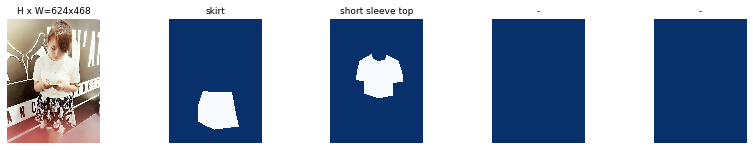

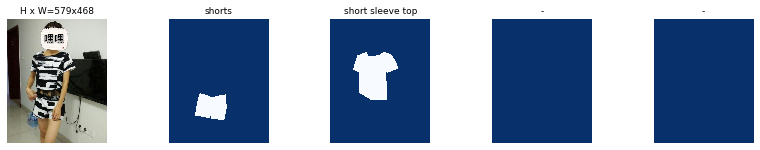

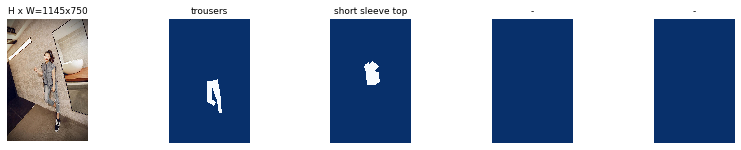

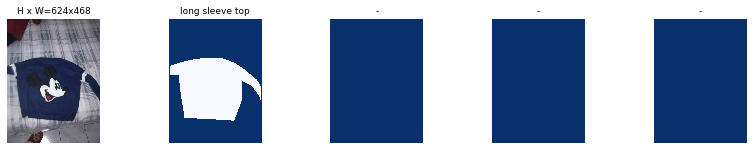

In [6]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
init_with = "imagenet"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/anton/Documents/deep_proj/deepfashion-project/Mask_RCNN/logs/fashion20191001T1808/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_ma

/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




/Users/anton/Documents/deep_proj/myenv/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


ERROR:root:Error processing image {'id': '000092', 'source': 'fashion', 'path': '/Users/anton/Documents/deep_proj/deepfashion-project/Mask_RCNN/datasets/tiny_deepfashion2/train/image/000092.jpg', 'width': 880, 'height': 467, 'segmentations': [[[424.13, 284.87, 452.92, 285.72, 476.2, 284.87, 489.01, 285.93, 489.75, 292.92, 490.17, 312.94, 487.97, 378.53, 484.66, 423.29, 482.55, 448.69, 482.55, 463.92, 477.27, 465.57, 454.0, 466.2, 448.59, 464.32, 448.4, 459.6, 446.0, 452.6, 445.2, 446.8, 444.62, 434.88, 443.6, 423.8, 438.95, 397.55, 430.91, 326.36, 421.17, 361.06, 414.4, 404.24, 412.71, 422.44, 410.17, 441.07, 406.78, 455.03, 406.78, 465.19, 402.31, 465.63, 374.88, 465.52, 372.49, 465.19, 373.58, 451.7, 373.51, 439.8, 371.65, 414.4, 367.45, 366.27, 366.46, 326.47, 365.96, 289.93, 375.46, 284.03]], [[481.54, 55.19, 489.99, 78.85, 494.49, 111.51, 482.1, 130.1, 466.9, 175.72, 454.51, 201.06, 439.3, 143.62, 425.22, 105.32, 432.54, 64.21, 432.54, 55.19, 385.39, 70.36, 369.3, 81.49, 358.16, 1

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': '000067', 'source': 'fashion', 'path': '/Users/anton/Documents/deep_proj/deepfashion-project/Mask_RCNN/datasets/tiny_deepfashion2/train/image/000067.jpg', 'width': 468, 'height': 624, 'segmentations': [[[209.84, 518.96, 278.02, 504.82, 302.6, 487.94, 328.27, 467.34, 360.39, 452.0, 364.94, 531.47, 363.33, 570.76, 348.32, 594.71, 313.32, 611.71, 255.36, 598.03, 229.98, 567.87, 217.07, 560.71, 198.09, 554.02, 161.46, 539.71, 155.1, 541.29, 138.32, 529.29, 130.97, 505.64, 112.71, 480.32, 106.27, 463.92, 111.27, 462.92, 157.51, 502.48]], [[1.0, 0.0, 20.0, 0.0, 92.0, 0.0, 148.0, 0.0, 157.0, 3.0, 162.0, 9.0, 164.0, 15.0, 175.0, 25.0, 209.0, 42.0, 252.0, 35.0, 281.0, 23.0, 289.0, 21.0, 299.0, 15.0, 304.0, 13.0, 308.0, 11.0, 313.0, 8.0, 327.0, 1.0, 371.0, 1.0, 430.0, 1.0, 462.0, 0.0, 466.0, 4.0, 467.0, 34.0, 467.0, 91.0, 468.0, 196.0, 467.0, 410.0, 443.0, 405.0, 438.0, 345.0, 428.0,

TypeError: only integer scalar arrays can be converted to a scalar index
ERROR:root:Error processing image {'id': '000002', 'source': 'fashion', 'path': '/Users/anton/Documents/deep_proj/deepfashion-project/Mask_RCNN/datasets/tiny_deepfashion2/train/image/000002.jpg', 'width': 468, 'height': 702, 'segmentations': [[[220.25, 187.55, 259.6, 177.6, 296.6, 158.6, 311.6, 148.2, 327.0, 146.4, 339.4, 144.6, 350.2, 145.2, 379.0, 145.2, 401.8, 148.2, 415.0, 159.0, 427.2, 183.8, 434.4, 212.4, 439.6, 255.6, 445.2, 280.8, 439.2, 292.8, 429.0, 301.0, 417.4, 306.6, 416.8, 324.8, 419.6, 344.8, 423.6, 364.2, 425.4, 380.2, 432.0, 400.0, 434.37, 414.51, 437.06, 428.4, 442.13, 440.2, 442.6, 453.2, 444.0, 476.0, 402.0, 506.0, 352.0, 523.0, 290.02, 531.28, 283.01, 503.18, 274.63, 456.91, 271.37, 432.95, 259.12, 394.55, 256.75, 375.73, 248.2, 355.7, 236.08, 358.71, 225.06, 357.45, 204.98, 348.01, 174.83, 305.67, 172.13, 255.97, 177.0, 221.0, 184.0, 214.0, 196.0, 210.4, 207.2, 199.6, 213.0, 196.8]], [[145.21

StopIteration: 